In [2]:
import tensorflow as tf
from tensorflow import keras

import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

mpl.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['axes.grid'] = False

import plotly.offline as py
# That's line needed if you use jupyter notebook (.ipynb):
py.init_notebook_mode(connected=True)

import plotly.graph_objects as go

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# Create candlestick chart to visualize Netflix (Symbol: NFLX) values across time from 5 years ago to present
tickerSymbol = 'TSLA'
today = datetime.date.today()
start = datetime.datetime(today.year-5,today.month,today.day)

def dataFrame(symbol, period, startdate, enddate):
    
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period=period, start=startdate, end=enddate)
    
    return tickerDf[['Close']]

df = dataFrame(tickerSymbol, '1d', start, today)
df.head()


,Close
Date,
2017-08-18,69.491997
2017-08-21,67.571999
2017-08-22,68.269997
2017-08-23,70.554001
2017-08-24,70.585999


# Preparing the data

In [5]:
def dataFrame(symbol, period, startdate, enddate):
    
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period=period, start=startdate, end=enddate)
    
    return tickerDf[columns]

df = dataFrame(tickerSymbol, '1d', start, today)

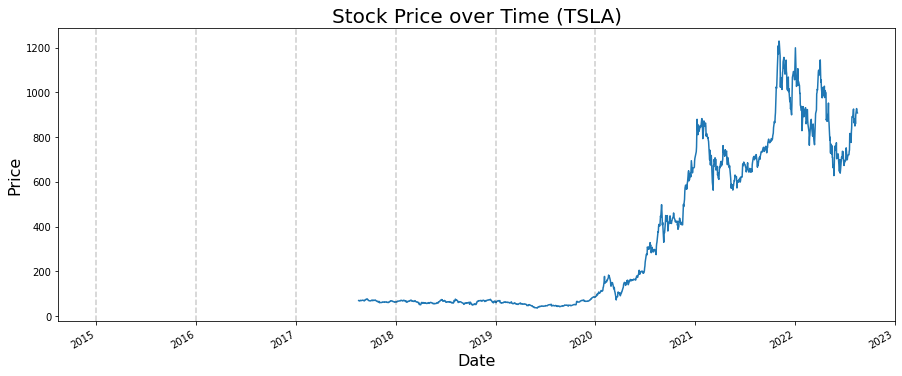

In [6]:
def plotChart(df):
    plt.figure(figsize=(15,6))
    df['Close'].plot()
    plt.title('Stock Price over Time (%s)'%tickerSymbol, fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    
    for year in range(2015,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plotChart(df)

In [7]:
# Split dataset 80:20 train:test
# Print length of subsets
df1 = df[['Close']]

train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size

# Standarize dataset values to reduce loss
train_mean = df1[:train_size].mean()
train_std = df1[:train_size].std()

df1 = (df1-train_mean)/train_std

train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]
print(len(train), len(test))

1007 252


In [8]:
# Values of training dataset now standardize
train

,Close
Date,
2017-08-18,-0.604560
2017-08-21,-0.612389
2017-08-22,-0.609543
2017-08-23,-0.600230
2017-08-24,-0.600100
...,...
2021-08-12,2.056873
2021-08-13,2.036161
2021-08-16,1.909768


In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
# (samples, time_steps, features)
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(1006, 1, 1) (1006,)


# Building the model

In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [12]:
X_train.shape[-2:]

(1, 1)

In [13]:
def build_model(LSTM_unit, dropout, lr, train):
    model = Sequential()
    model.add(LSTM(units=LSTM_unit,return_sequences=True,input_shape=(train.shape[-2:])))
    model.add(Dropout(dropout))

    model.add(LSTM(units=LSTM_unit,return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=LSTM_unit,return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=LSTM_unit))
    model.add(Dropout(dropout))

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(lr),loss='mean_squared_error')
    
    return model

model = build_model(50, 0.2, 0.001, X_train)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/50
8/8 [==============================] - 12s 316ms/step - loss: 0.7494 - val_loss: 3.3440
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.7355 - val_loss: 3.3367
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.7298 - val_loss: 3.3084
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.7198 - val_loss: 3.2498
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.7006 - val_loss: 3.1337
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.6644 - val_loss: 2.9138
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.5991 - val_loss: 2.5269
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4900 - val_loss: 1.9094
Epoch 9/50
8/8 [==============================] - 0s 23ms/step - loss: 0.3434 - val_loss: 1.0626
Epoch 10/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1690 - val_loss: 0.2482
Epoch 11/50
8/8 [==========

# Evaluating the model

<module 'matplotlib.pyplot' from 'c:\\Program Files\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

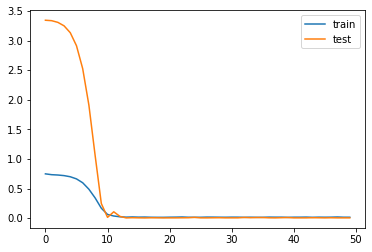

In [16]:
def loss_plot(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    
    return plt

loss_plot(history)

In [17]:
# Calculate original values
y_inv = (y_train*int(train_std))+int(train_mean)
ytest_inv = (y_test*int(train_std))+int(train_mean)

# Calculate predicted values
y_pred = model.predict(X_test)
ypred_inv = (y_pred*int(train_std))+int(train_mean)

#calculate accuracy level
#accuracy_score(ytest_inv,ypred_inv)


8/8 [==============================] - 2s 2ms/step


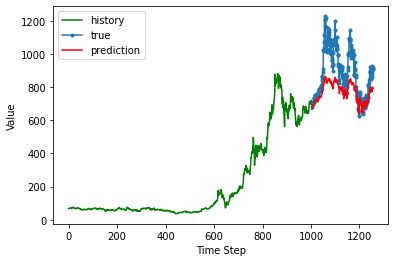

<module 'matplotlib.pyplot' from 'c:\\Program Files\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [18]:
def full_plot(y_inv, ytest_inv, ypred_inv):
    plt.plot(np.arange(0, len(y_inv)), y_inv, 'g', label="history")
    plt.plot(np.arange(len(y_inv), len(y_inv) + len(ytest_inv)), ytest_inv, marker='.', label="true")
    plt.plot(np.arange(len(y_inv), len(y_inv) + len(ytest_inv)), ypred_inv, 'r', label="prediction")
    plt.ylabel('Value')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()
    
    return plt

full_plot(y_inv, ytest_inv, ypred_inv)

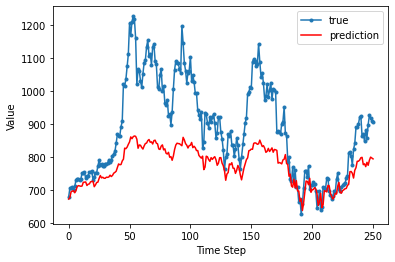

<module 'matplotlib.pyplot' from 'c:\\Program Files\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [19]:
def compare_value_plot(y_inv, ytest_inv, ypred_inv):
    plt.plot(ytest_inv, marker='.', label="true")
    plt.plot(ypred_inv, 'r', label="prediction")
    plt.ylabel('Value')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()
    
    return plt

compare_value_plot(y_inv, ytest_inv, ypred_inv)

In [20]:
import math
import numpy as np

In [21]:
MSE = np.square(np.subtract(ytest_inv,ypred_inv)).mean()
print(MSE)

36964.11797049466


In [22]:
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

192.26054709818825
